In [1]:
import json
import pandas as pd
from utils import preprocessing, set_index
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras import models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
from dc_vae_continual import DCVAE, Sampling
from utils import samples_conditions_embedd
import pickle
from statsmodels.graphics.tsaplots import plot_acf

2023-06-22 17:21:48.443639: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
settings_path = 'settings/model_settings_continual.txt'
settings = json.load(open(settings_path, 'r'))
print(settings)

{'dataset_name': 'TELCO', 'model_name': 'dc-vae_continual', 'scale': False, 'wo_outliers': True, 'max_std': 7, 'T': 128, 'M': 12, 'cnn_units': [64, 128, 128, 128, 128, 128, 64], 'dil_rate': [1, 2, 4, 8, 16, 32, 64], 'kernel': 2, 'strs': 1, 'activation': 'selu', 'alpha_reg': 0.0001, 'batch_size': 32, 'J': 64, 'epochs': 200, 'lr': 0.0001, 'lr_decay': False, 'decay_rate': 0.96, 'decay_step': 7000, 'val_percent': 0.2, 'time_embedding': False, 'summary': True, 'save_best_model': False, 'save_complete_model': True}


In [3]:

#path = '../../Datasets/TELCO/'
path = "/home/gastong/Documentos/TELCO/v1/" #Rosaluna
filenames_train = ["TELCO_data_2021_01.zip", 
                   #"TELCO_data_2021_02.zip", "TELCO_data_2021_03.zip",
                #"TELCO_data_2021_04.zip", "TELCO_data_2021_05.zip", "TELCO_data_2021_06.zip",
                #"TELCO_data_2021_07.zip", "TELCO_data_2021_08.zip", "TELCO_data_2021_09.zip",
                #"TELCO_data_2021_10.zip", "TELCO_data_2021_11.zip", "TELCO_data_2021_12.zip"
                ]
files_train = [path+ i for i in filenames_train]

# Load data and predictions
# Read CSV files from List
data_train = pd.concat(map(pd.read_csv, files_train))
data_train = set_index(data_train)
data_train = preprocessing(data_train, flag_scaler=False, outliers=True)
data_train.head()

,TS1,TS2,TS3,TS4,TS5,TS6,TS7,TS8,TS9,TS10,TS11,TS12
time,,,,,,,,,,,,
2021-01-01 00:00:00,0.790423,0.572709,0.576859,0.786895,0.845216,0.655201,0.723233,0.795858,0.407110,0.80,0.008386,0.010724
2021-01-01 00:05:00,0.774003,0.540110,0.576859,0.794884,0.843063,0.717850,0.560724,0.650888,0.407110,0.80,0.008386,0.010724
2021-01-01 00:10:00,0.743711,0.532618,0.762395,0.809906,0.826144,0.639912,0.530483,0.618343,0.407110,0.80,0.008386,0.010724
2021-01-01 00:15:00,0.768127,0.517837,0.762395,0.751709,0.834179,0.641776,0.538414,0.603550,0.103483,0.45,0.001316,0.008043
2021-01-01 00:20:00,0.734526,0.495463,0.517999,0.664537,0.908283,1.184732,0.501817,0.568047,0.103483,0.45,0.001316,0.008043


In [4]:

#path = '../../Datasets/TELCO/'
path = "/home/gastong/Documentos/TELCO/v1/" #Rosaluna
filenames_test = ["TELCO_data_2022_01.zip", 
               "TELCO_data_2022_02.zip", "TELCO_data_2022_03.zip",
               "TELCO_data_2022_04.zip", "TELCO_data_2022_05.zip", "TELCO_data_2022_06.zip",
               "TELCO_data_2022_07.zip", "TELCO_data_2022_08.zip", "TELCO_data_2022_09.zip",
                #"TELCO_data_2022_10.zip", "TELCO_data_2022_11.zip", "TELCO_data_2022_12.zip"
                ]
files_test = [path+ i for i in filenames_test]

# Load data and predictions
# Read CSV files from List
data_test = pd.concat(map(pd.read_csv, files_test))
data_test = set_index(data_test)
data_test = preprocessing(data_test, flag_scaler=False, outliers=True)
data_test.head()

,TS1,TS2,TS3,TS4,TS5,TS6,TS7,TS8,TS9,TS10,TS11,TS12
time,,,,,,,,,,,,
2022-01-01 00:00:00,0.648864,0.505284,0.669942,0.837027,0.623184,0.535870,0.634853,0.668639,0.247535,0.875,0.021380,0.021448
2022-01-01 00:05:00,0.649752,0.497994,0.669942,0.820139,0.580578,0.441524,0.590735,0.582840,0.247535,0.875,0.021380,0.021448
2022-01-01 00:10:00,0.593288,0.476937,0.704539,0.777010,0.643936,0.459797,0.548041,0.520710,0.247535,0.875,0.021380,0.021448
2022-01-01 00:15:00,0.544374,0.467724,0.704539,0.835551,0.570099,0.418404,0.556218,0.523669,0.151931,0.575,0.014328,0.016086
2022-01-01 00:20:00,0.611489,0.443933,0.516019,0.795907,0.523654,0.401623,0.632546,0.588757,0.151931,0.575,0.014328,0.016086


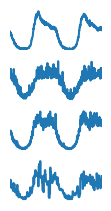

In [5]:
#define number of rows and columns for subplots
nrow=4
ncol=1

columns_list = data_train.columns

time_start = '2021-01-11'
time_end = '2021-01-12'
fig, axes = plt.subplots(nrow, ncol, figsize=(1,2), constrained_layout=True, sharex=True)

# plot counter
count=0

for r in range(nrow):
    for c in range(ncol):
        data_train[columns_list[count]][time_start:time_end].plot(ax=axes[r])
        axes[r].axis('off')
        count+=3
plt.savefig('images/input.png', transparent=True)

In [6]:
# Model initialization
model = DCVAE(
    settings['T'],
    settings['M'],
    settings['cnn_units'],
    settings['dil_rate'],
    settings['kernel'],
    settings['strs'],
    settings['batch_size'],
    settings['J'],
    settings['lr'],
    settings['lr_decay'],
    settings['decay_rate'],
    settings['decay_step'],
    settings['time_embedding'],
    settings['summary'],
    ) 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2023-06-22 17:21:50.787848: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-06-22 17:21:50.788508: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-06-22 17:21:50.803656: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-22 17:21:50.803898: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA TITAN Xp computeCapability: 6.1
coreClock: 1.582GHz coreCount: 30 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 510.07GiB/s
2023-06-22 17:21:50.803915: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-06-22 17:21:50.805072: I tensorflow/stream_executor/platform/default/d

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_samples (InputLayer)      [(None, 128, 12)]    0                                            
__________________________________________________________________________________________________
dcnn_enc_0 (Conv1D)             (None, 128, 64)      1536        input_samples[0][0]              
__________________________________________________________________________________________________
dcnn_enc_1 (Conv1D)             (None, 128, 128)     16384       dcnn_enc_0[0][0]                 
__________________________________________________________________________________________________
dcnn_enc_2 (Conv1D)             (None, 128, 128)     32768       dcnn_enc_1[0][0]                 
____________________________________________________________________________________________

In [7]:
anom_train, error_train, reconst_train, sig_train, latent_space = model.predict(data_train,
                                        True,
                                        large_result=True,
                                        load_alpha=False,
                                        alpha_set_up = list(np.ones(12)),
                                        alpha_set_down = list(np.ones(12)),
                                        name=settings["model_name"]
                                                    )
th_up_train = reconst_train + sig_train
th_down_train = reconst_train - sig_train

2023-06-22 17:21:52.273473: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-06-22 17:21:52.273798: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3699850000 Hz
2023-06-22 17:21:52.566950: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-06-22 17:21:53.033052: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-06-22 17:21:53.092714: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-06-22 17:21:53.642115: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


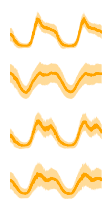

In [8]:
#define number of rows and columns for subplots
nrow=4
ncol=1

columns_list = data_train.columns

time_start = '2021-01-11'
time_end = '2021-01-12'
fig, axes = plt.subplots(nrow, ncol, figsize=(1,2), constrained_layout=True, sharex=True)

# plot counter
count=0

for r in range(nrow):
    for c in range(ncol):
        reconst_train[columns_list[count]][time_start:time_end].plot(ax=axes[r], color='orange')
        axes[r].fill_between(reconst_train[columns_list[count]][time_start:time_end].index,
                         th_up_train[columns_list[count]][time_start:time_end],
                         th_down_train[columns_list[count]][time_start:time_end],
                         facecolor='orange', alpha=0.4, interpolate=True)
        axes[r].axis('off')
        count+=3
plt.savefig('images/output.png', transparent=True)

In [9]:
anomaly = ((th_down_train >= data_train[settings['T']-1:]) | (th_up_train <= data_train[settings['T']-1:])).astype(int)

(26844480.0, 26850235.0, -0.28114910125732423, 1.5227715492248535)

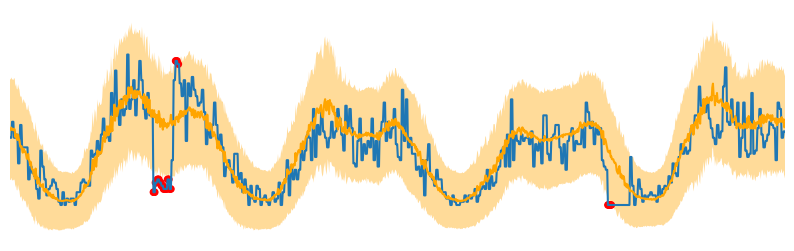

In [9]:
plt.figure(figsize=(10,3))
count = 9
time_start = '2021-01-15'
time_end = '2021-01-18'
data_train[columns_list[count]][time_start:time_end].plot()
reconst_train[columns_list[count]][time_start:time_end].plot(color='orange')
plt.fill_between(reconst_train[columns_list[count]][time_start:time_end].index,
    th_up_train[columns_list[count]][time_start:time_end],
    th_down_train[columns_list[count]][time_start:time_end],
    facecolor='orange', alpha=0.4, interpolate=True)
plt.scatter(data_train[columns_list[count]][time_start:time_end].index,
            data_train[columns_list[count]][time_start:time_end].values,
            s=20*anomaly[columns_list[count]][time_start:time_end],
            color='red')
plt.axis('off')
#plt.savefig('images/detection.png', transparent=True)

(26858880.0, 26864635.0, -0.7225550292452281, 1.4785899965884504)

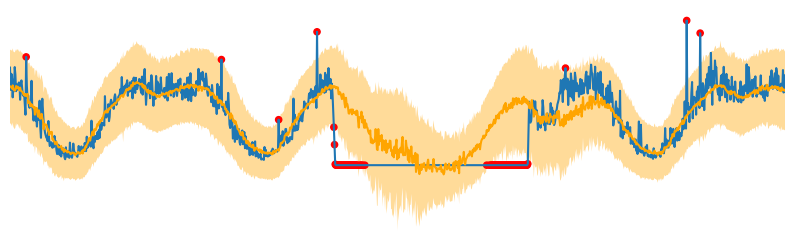

In [10]:
plt.figure(figsize=(10,3))
count = 3
time_start = '2021-01-25'
time_end = '2021-01-28'
data_train[columns_list[count]][time_start:time_end].plot()
reconst_train[columns_list[count]][time_start:time_end].plot(color='orange')
plt.fill_between(reconst_train[columns_list[count]][time_start:time_end].index,
    th_up_train[columns_list[count]][time_start:time_end],
    th_down_train[columns_list[count]][time_start:time_end],
    facecolor='orange', alpha=0.4, interpolate=True)
plt.scatter(data_train[columns_list[count]][time_start:time_end].index,
            data_train[columns_list[count]][time_start:time_end].values,
            s=20*anomaly[columns_list[count]][time_start:time_end],
            color='red')
plt.axis('off')
#plt.savefig('images/detection.png', transparent=True)

(26844480.0, 26850235.0, -0.17557037733495234, 1.469385788962245)

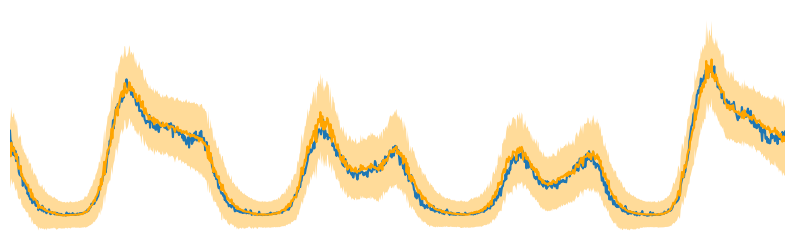

In [12]:
plt.figure(figsize=(10,3))
count = 0
time_start = '2021-01-15'
time_end = '2021-01-18'
data_train[columns_list[count]][time_start:time_end].plot()
reconst_train[columns_list[count]][time_start:time_end].plot(color='orange')
plt.fill_between(reconst_train[columns_list[count]][time_start:time_end].index,
    th_up_train[columns_list[count]][time_start:time_end],
    th_down_train[columns_list[count]][time_start:time_end],
    facecolor='orange', alpha=0.4, interpolate=True)
plt.scatter(data_train[columns_list[count]][time_start:time_end].index,
            data_train[columns_list[count]][time_start:time_end].values,
            s=20*anomaly[columns_list[count]][time_start:time_end],
            color='red')
plt.axis('off')
#plt.savefig('images/detection.png', transparent=True)

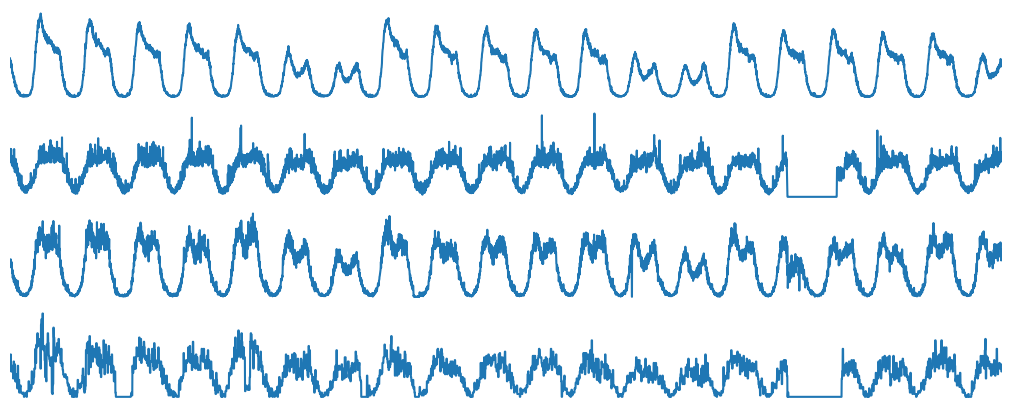

In [11]:
#define number of rows and columns for subplots
nrow=4
ncol=1

columns_list = data_train.columns

time_start = '2021-01-11'
time_end = '2021-01-30'
fig, axes = plt.subplots(nrow, ncol, figsize=(10,4), constrained_layout=True, sharex=True)

# plot counter
count=0

for r in range(nrow):
    for c in range(ncol):
        data_train[columns_list[count]][time_start:time_end].plot(ax=axes[r])
        axes[r].axis('off')
        count+=3
plt.savefig('images/example_mulit_TELCO_.png', transparent=True)

### CD

In [25]:
anom_test, error_test, reconst_test, sig_test, latent_space = model.predict(data_test,
                                        True,
                                        large_result=True,
                                        load_alpha=False,
                                        alpha_set_up = list(np.ones(12)),
                                        alpha_set_down = list(np.ones(12)),
                                        name=settings["model_name"]
                                                    )
th_up_test = reconst_test + sig_test
th_down_test = reconst_test - sig_test

In [41]:
noise2gen = np.random.normal(0, 0.3, (reconst_test.shape))
X_gen = reconst_test + noise2gen*(sig_test)

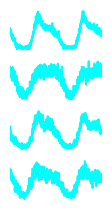

In [42]:
#define number of rows and columns for subplots
nrow=4
ncol=1

columns_list = data_train.columns

time_start = '2022-01-11'
time_end = '2022-01-12'
fig, axes = plt.subplots(nrow, ncol, figsize=(1,2), constrained_layout=True, sharex=True)

# plot counter
count=0

for r in range(nrow):
    for c in range(ncol):
        X_gen[columns_list[count]][time_start:time_end].plot(ax=axes[r], color='cyan')
        axes[r].axis('off')
        count+=3
plt.savefig('images/generated.png', transparent=True)

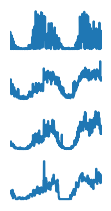

In [44]:
#define number of rows and columns for subplots
nrow=4
ncol=1

columns_list = data_train.columns

time_start = '2022-09-15'
time_end = '2022-09-16'
fig, axes = plt.subplots(nrow, ncol, figsize=(1,2), constrained_layout=True, sharex=True)

# plot counter
count=0

for r in range(nrow):
    for c in range(ncol):
        data_test[columns_list[count]][time_start:time_end].plot(ax=axes[r])
        axes[r].axis('off')
        count+=3
plt.savefig('images/input_CD.png', transparent=True)

In [ ]:
#define number of rows and columns for subplots
nrow=4
ncol=1

columns_list = data_train.columns

time_start = '2021-01-11'
time_end = '2021-01-12'
fig, axes = plt.subplots(nrow, ncol, figsize=(1,2), constrained_layout=True, sharex=True)

# plot counter
count=0

for r in range(nrow):
    for c in range(ncol):
        reconst_train[columns_list[count]][time_start:time_end].plot(ax=axes[r], color='orange')
        axes[r].fill_between(reconst_train[columns_list[count]][time_start:time_end].index,
                         th_up_train[columns_list[count]][time_start:time_end],
                         th_down_train[columns_list[count]][time_start:time_end],
                         facecolor='orange', alpha=0.4, interpolate=True)
        axes[r].axis('off')
        count+=3
plt.savefig('images/output.png', transparent=True)

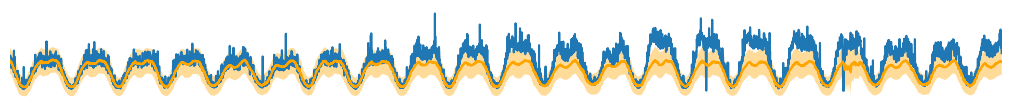

In [15]:
plt.figure(figsize=(10,1), constrained_layout=True)


time_start = '2022-02-08'
time_end = '2022-02-28'

data_test['TS4'][time_start:time_end].plot()
reconst_test['TS4'][time_start:time_end].plot(color='orange')
plt.fill_between(reconst_test['TS4'][time_start:time_end].index,
    th_up_test['TS4'][time_start:time_end],
    th_down_test['TS4'][time_start:time_end],
    facecolor='orange', alpha=0.4, interpolate=True)
plt.axis('off')
plt.savefig('images/CD_real_TELCO.png', transparent=True)

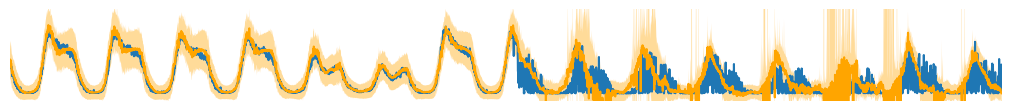

In [29]:
plt.figure(figsize=(10,1), constrained_layout=True)


time_start = '2022-09-06'
time_end = '2022-09-20'

data_test['TS1'][time_start:time_end].plot()
reconst_test['TS1'][time_start:time_end].plot(color='orange')
plt.fill_between(reconst_test['TS1'][time_start:time_end].index,
    th_up_test['TS1'][time_start:time_end],
    th_down_test['TS1'][time_start:time_end],
    facecolor='orange', alpha=0.4, interpolate=True)
plt.ylim(-0.1, 1.1)
plt.axis('off')
plt.savefig('images/CD_real_TELCO_2.png', transparent=True)

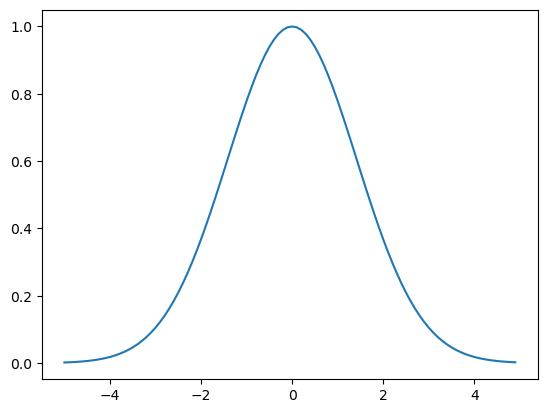

In [16]:
mu = 0
sig = 1

x = np.arange(-5, 5, 0.1)

L = np.exp(-((x-mu)**2)/(2*sig*2))

plt.plot(x, L)
plt.savefig('images/likelihood_ex.png', transparent=True)

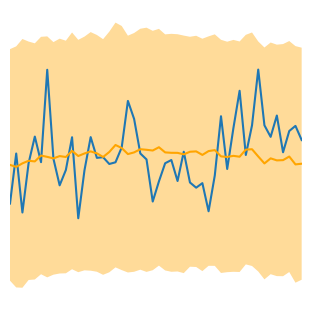

In [17]:
plt.figure(figsize=(3,3), constrained_layout=True)


time_start = '2022-02-08 20'
time_end = '2022-02-08'

data_test['TS4'][time_start:time_end].plot()
reconst_test['TS4'][time_start:time_end].plot(color='orange')
plt.fill_between(reconst_test['TS4'][time_start:time_end].index,
    th_up_test['TS4'][time_start:time_end],
    th_down_test['TS4'][time_start:time_end],
    facecolor='orange', alpha=0.4, interpolate=True)
plt.axis('off')
plt.savefig('images/likelihood_serie_ex_zoom.png', transparent=True)

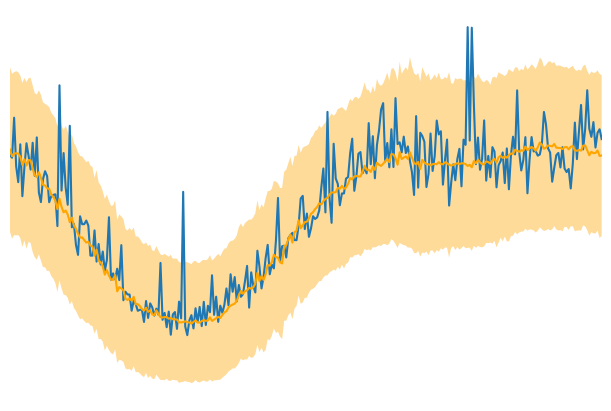

In [18]:
plt.figure(figsize=(6,4), constrained_layout=True)


time_start = '2022-02-08'
time_end = '2022-02-08'

data_test['TS4'][time_start:time_end].plot()
reconst_test['TS4'][time_start:time_end].plot(color='orange')
plt.fill_between(reconst_test['TS4'][time_start:time_end].index,
    th_up_test['TS4'][time_start:time_end],
    th_down_test['TS4'][time_start:time_end],
    facecolor='orange', alpha=0.4, interpolate=True)
plt.axis('off')
plt.savefig('images/likelihood_serie_ex.png', transparent=True)

In [19]:
def likelihood_norm(x, mu, sigma):
    return (np.exp(-0.5*((x-mu)/sigma)**2))

In [20]:
likelihood_test = likelihood_norm(data_test[settings['T']-1:], reconst_test, sig_test)

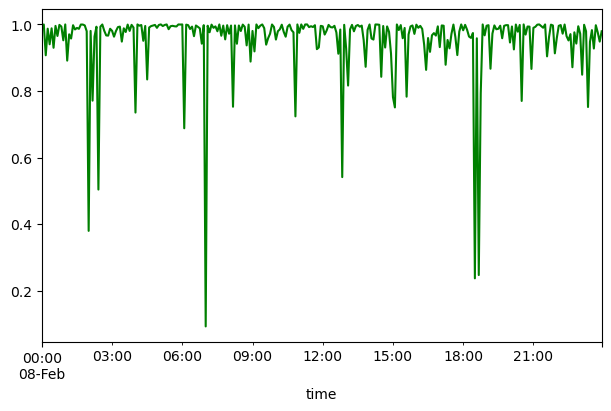

In [21]:
plt.figure(figsize=(6,4), constrained_layout=True)


time_start = '2022-02-08'
time_end = '2022-02-08'

likelihood_test['TS4'][time_start:time_end].plot(color='green')

plt.savefig('images/likelihood_value_ex.png', transparent=True)

In [45]:
noise = np.random.normal(0, 0.1, (3*(data_train.shape[0]//10), 1, settings['J']))

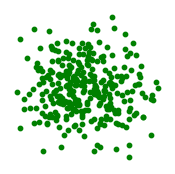

In [59]:
plt.figure(figsize=[2,2])
plt.scatter(noise[:300,0,0], noise[:300,0,1], c='green', s=10)
plt.axis('off')
plt.savefig('images/gauss_noise.png', transparent=True)

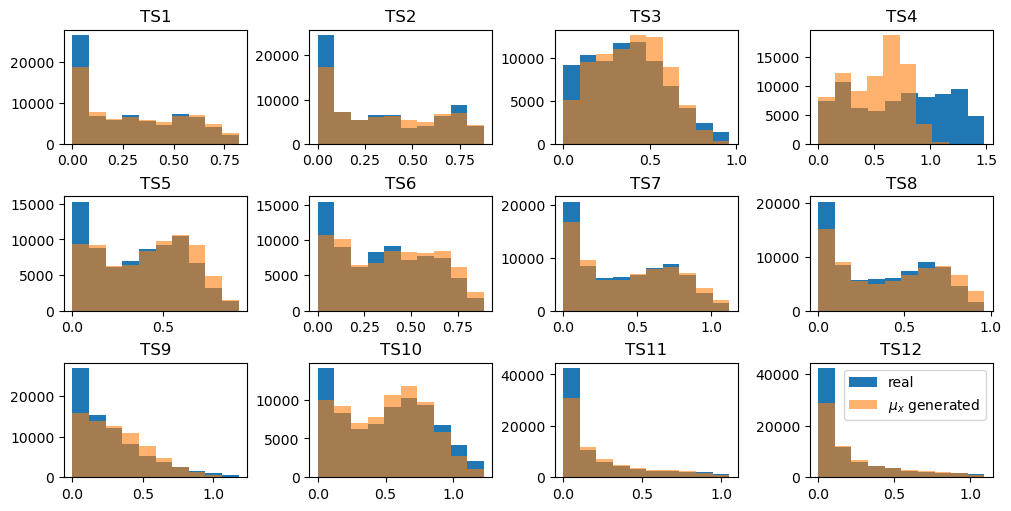

In [61]:
fig, axes = plt.subplots(3, 4, figsize=(10,5), constrained_layout=True)
i = 0
data= data_test[settings['T']-1:]
for x in range(3):
    for y in range(4):
        data.iloc[:, i][data.iloc[:, i].between(data.iloc[:, i].min(), data.iloc[:, i].quantile(.98))].hist(ax=axes[x,y])
        X_gen.iloc[:, i][X_gen.iloc[:, i].between(data.iloc[:, i].min(), data.iloc[:, i].quantile(.98))].hist(alpha=0.6, ax=axes[x,y])
        axes[x,y].title.set_text(data.columns[i])
        axes[x,y].grid(False)
        i += 1
plt.legend(['real', r'$\mu_x$ generated'])
#plt.savefig('hist_real_gen.pdf')